<a href="https://colab.research.google.com/github/inesochoa/lisbon-ml-school/blob/miochoa-exercises/exercise_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tutorial on unsupervised learning for anomaly detection
=============

ML for Physics @ LIP: https://indico.lip.pt/event/1909/

Author: Inês Ochoa

# Introduction

The ATLAS and CMS experiments at the LHC are exploring the vast proton-proton collision dataset in search for signals of beyond the Standard Model (BSM) phenomena that can help explain some of the open questions in fundamental physics.
Typically, searches for BSM are conducted in a fully-supervised approach: the final state for the signal hypothesis is clearly defined and the event selection and optimisation is performed towards that particular class of signal model.

Given all the null results observed by the many BSM searches underway, experimentalists should consider whether the data could contain new physics that isn't being tested for. Therefore, an alternative approach that increases signal model independence is to frame BSM searches as an anomaly detection (AD) problem. Unsupervised learning is one possible way of doing AD, which will be exemplified here. In short, an unsupervised algorithm is trained to learn the known SM processes (in data or simulation, with different challenges in each case), and in that way being able to identify BSM events as anomalies, without having been trained on them.

We will explore two different methods, but there are many more in the literature!
* Auto-encoders
* Variational-autoencoders

# Setting up libraries

In [ ]:
# some libraries to install:
#! pip install --quiet pytorch-lightning>=1.4
#! pip install matplotlib
#! pip install vector
#! pip install awkward

In [17]:
import numpy as np
import pandas as pd
import h5py
import math
import os
import pathlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import vector
import awkward

from tqdm import tqdm
%matplotlib inline
import itertools
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import numpy.ma as ma

from sklearn.model_selection import train_test_split

## PyTorch
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.utils.data as data
import torch.optim as optim
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint


In [3]:
# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

# useful for later
CHECKPOINT_PATH = "saved_models/" # define a directory for saving the checkpoints
os.makedirs(CHECKPOINT_PATH, exist_ok=True)
os.environ["TORCH_HOME"] = CHECKPOINT_PATH

os.makedirs(CHECKPOINT_PATH+"/LHCO-task", exist_ok=True)


INFO:lightning_fabric.utilities.seed:Seed set to 42


Device: cuda:0


In [4]:
import gc
torch.cuda.empty_cache()
gc.collect()

290

In [5]:
os.environ["DATAPATH"] = "lhc_olympics_dataset/"
os.makedirs(os.environ["DATAPATH"], exist_ok=True) # change path to what you need

# The dataset
The dataset used in this exercise was provided in the context of the [LHC Olympics 2020](https://lhco2020.github.io/homepage/).

The background consists of 1 M QCD di-jet events. The two signal samples consist of:
* 2-prong: 100k $W^\prime \rightarrow XY$ events, where $W^\prime$, $X$ and $Y$ are all hypothetical new particles with masses 3.5 TeV, 500 GeV and 100 GeV respectively. The bosons $X$ and $Y$ decay hadronically in 2-prong decays to $X\rightarrow qq$ and $Y\rightarrow qq$.
* 3-prong: same as above but $Y$ decays to 3-quarks as $Y\rightarrow qqq$.

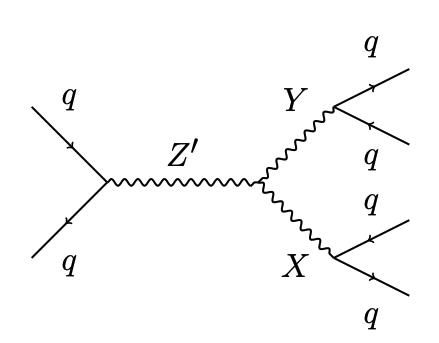

In [ ]:
# If you're running on your laptop / lip machine, download the input data by uncommenting the following lines:

#! wget https://zenodo.org/records/6466204/files/events_anomalydetection_v2.features.h5?download=1 -O Background_2prongSignal.h5
#! mv Background_2prongSignal.h5 $DATAPATH
#! wget https://zenodo.org/records/6466204/files/events_anomalydetection_Z_XY_qqq.features.h5?download=1 -O 3prongSignal.h5
#! mv 3prongSignal.h5 $DATAPATH


# If you're running on google colab and have previously downladed the files to your drive, you can also do the following:
# Load the Drive helper and mount
#from google.colab import drive

# This will prompt for authorization.
#drive.mount('/content/drive/')

#os.environ["DATAPATH"] = "path-to-dataset" # replace this

In [7]:
! ls $DATAPATH

3prongSignal.h5  Background_2prongSignal.h5


In [8]:
df_combined = pd.read_hdf(os.environ["DATAPATH"] + '/Background_2prongSignal.h5')
print(df_combined.shape)
print("Memory in GB:",sum(df_combined.memory_usage(deep=True)) / (1024**3))

(1100000, 15)
Memory in GB: 0.13113021850585938


In [10]:
df_combined

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,mj2,tau1j2,tau2j2,tau3j2,label
0,-1467.239990,611.502014,511.101990,38.896000,8.290660,4.836080,4.260190,1403.579956,-674.551025,-451.670990,237.893997,79.815102,21.010300,16.757601,0.0
1,-1211.239990,347.315002,547.963013,389.532013,191.804001,99.562798,70.872200,619.341003,-62.177299,-1944.040039,22.999201,8.042190,6.335090,5.525360,0.0
2,-1229.619995,649.857971,8.089170,72.155502,47.168098,37.243198,33.658199,1196.250000,-647.896973,-1283.109985,78.230698,15.292900,13.944200,10.013500,0.0
3,-693.304016,-1046.729980,1716.910034,55.797798,24.788601,6.890150,5.813390,747.961975,994.250000,-412.966003,359.113007,175.209000,103.500999,84.447098,0.0
4,-1488.199951,-25.370100,-30.989700,84.891502,26.878799,15.517200,13.260400,1415.640015,20.905100,223.630997,77.506500,57.986000,34.147400,26.660601,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099995,1069.660034,659.874023,218.751007,126.183998,122.486000,27.608700,17.924801,-956.169006,-297.311005,-2204.350098,108.889999,21.177299,10.582400,9.138600,1.0
1099996,-1286.619995,-86.162498,-1366.270020,115.719002,109.853996,29.830200,22.489201,1145.729980,136.792007,1216.780029,489.053009,416.747009,84.599998,66.767502,1.0
1099997,-149.330002,1781.459961,-58.690899,508.045013,495.290985,82.283600,43.567902,84.726700,-1378.569946,-1485.469971,91.104897,79.120102,46.537300,23.227301,1.0
1099998,1584.699951,-731.156982,-196.348007,114.938004,83.769897,12.898200,9.031230,-1515.079956,783.245972,498.704010,553.737000,366.188995,192.139008,81.398201,1.0


In [11]:
df_combined.columns

Index(['pxj1', 'pyj1', 'pzj1', 'mj1', 'tau1j1', 'tau2j1', 'tau3j1', 'pxj2',
       'pyj2', 'pzj2', 'mj2', 'tau1j2', 'tau2j2', 'tau3j2', 'label'],
      dtype='object')

The background and signal files include only "high-level" features of the event. The events were clustered with R=1 anti-kt jets and the information on the two leading jets saved: their 3-momenta, invariant masses, n-subjettiness variables $\tau_1$, $\tau_2$ and $\tau_3$:

In [24]:
# remove "label" info
original_features = ['pxj1', 'pyj1', 'pzj1', 'mj1', 'tau1j1', 'tau2j1', 'tau3j1', 'pxj2',
       'pyj2', 'pzj2', 'mj2', 'tau1j2', 'tau2j2', 'tau3j2']

Now, split the dataset into background and signal:

In [25]:
df_bkg = df_combined[df_combined["label"]==0]
df_bkg.shape

(1000000, 15)

In [26]:
df_signal_two = df_combined[df_combined["label"]==1]
df_signal_two.shape

(100000, 15)

In [27]:
# and read in 3 prong file
df_signal_three = pd.read_hdf(os.environ["DATAPATH"] + '/3prongSignal.h5')
df_signal_three.shape

(100000, 14)

Let's start by making the plot of the di-jet invariant mass...

In [28]:
# use vector do make a 4-vector sum and calculate the mass
def get_dijet_mass(df):
  jet1_p4 = vector.zip({'px': df['pxj1'], 'py': df['pyj1'], 'pz': df['pzj1'], 'mass': df['mj1']})
  jet2_p4 = vector.zip({'px': df['pxj2'], 'py': df['pyj2'], 'pz': df['pzj2'], 'mass': df['mj2']})
  dijet = jet1_p4 + jet2_p4
  return dijet.mass

sigtwo_dijet_mass = get_dijet_mass(df_signal_two)
sigthree_dijet_mass = get_dijet_mass(df_signal_three)
bkg_dijet_mass = get_dijet_mass(df_bkg)

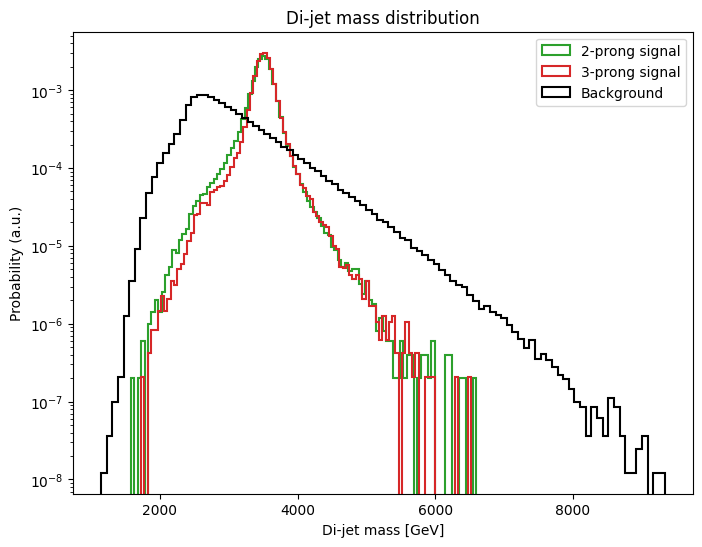

In [29]:
# make a plot
plt.figure(figsize=(8,6))
plt.hist(sigtwo_dijet_mass, bins=100, label="2-prong signal", color="C2", density = True, histtype='step', linewidth=1.5)
plt.hist(sigthree_dijet_mass, bins=100, label="3-prong signal", color="C3", density = True, histtype='step', linewidth=1.5)
plt.hist(bkg_dijet_mass, bins=100, label="Background", color="black", density = True, histtype='step', linewidth=1.5)
plt.yscale('log')
plt.xlabel("Di-jet mass [GeV]")
plt.ylabel("Probability (a.u.)")
plt.title('Di-jet mass distribution')
plt.legend(loc='best')
plt.show()

Let's calculate new features that contain information on the 2-jet systems, e.g. $\Delta \eta (j_1,j_2)$, where $\eta_1$ and $\eta_2$ are the jet's pseudo-rapidity.

In [31]:
def recalc_features(ds_original):
    ds = ds_original.copy()
    ds["ptj1"] = np.sqrt(np.square(ds["pxj1"])+np.square(ds["pyj1"]))
    etaj1 = np.arcsinh(ds["pzj1"]/ds["ptj1"])
    phi1 = np.arccos(ds["pxj1"]/ds["ptj1"])
    ds["ptj2"] = np.sqrt(np.square(ds["pxj2"])+np.square(ds["pyj2"]))
    etaj2 = np.arcsinh(ds["pzj2"]/ds["ptj2"])
    phi2 = np.arccos(ds["pxj2"]/ds["ptj2"])
    deta = etaj1-etaj2
    ds["deta"] = np.abs(deta)
    ds["tau21j1"] = np.where(ds["tau1j1"]>0, ds["tau2j1"]/ds["tau1j1"], 0)
    ds["tau32j1"] = np.where(ds["tau2j1"]>0, ds["tau3j1"]/ds["tau2j1"], 0)
    ds["tau21j2"] = np.where(ds["tau1j2"]>0, ds["tau2j2"]/ds["tau1j2"], 0)
    ds["tau32j2"] = np.where(ds["tau2j2"]>0, ds["tau3j2"]/ds["tau2j2"], 0)
    return ds

In [32]:
df_signal_three = recalc_features(df_signal_three)
df_signal_two = recalc_features(df_signal_two)
df_bkg = recalc_features(df_bkg)

In [33]:
df_bkg.columns

Index(['pxj1', 'pyj1', 'pzj1', 'mj1', 'tau1j1', 'tau2j1', 'tau3j1', 'pxj2',
       'pyj2', 'pzj2', 'mj2', 'tau1j2', 'tau2j2', 'tau3j2', 'label', 'ptj1',
       'ptj2', 'deta', 'tau21j1', 'tau32j1', 'tau21j2', 'tau32j2'],
      dtype='object')

Reduce dataset to include only the recalculated list of features (and transform into numpy):

In [34]:
new_features = ['ptj1', 'mj1', 'tau21j1', 'tau32j1', 'ptj2', 'mj2', 'tau21j2', 'tau32j2']#, 'deta']#, "mjj"]

In [35]:
df_bkg = df_bkg[new_features]
df_signal_two = df_signal_two[new_features]
df_signal_three = df_signal_three[new_features]

In [36]:
df_bkg = df_bkg.to_numpy()
df_signal_two = df_signal_two.to_numpy()
df_signal_three = df_signal_three.to_numpy()

Now let's define the training, test and validation datasets:

In [37]:
# background
X_train, X_test = train_test_split(df_bkg, test_size=0.2, shuffle=True)
X_train, X_val = train_test_split(X_train, test_size=0.2)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(640000, 8)
(200000, 8)
(160000, 8)


## Plotting the data

In [38]:
binning_map = {
    "ptj1": np.linspace(1000,2500,50),
    "ptj2": np.linspace(1000,2500,50),
    "mj1": np.linspace(0,1500,100),
    "mj2": np.linspace(0,1500,100),
    "tau21j1": np.linspace(0,1,50),
    "tau32j1": np.linspace(0,1,50),
    "tau21j2": np.linspace(0,1,50),
    "tau32j2": np.linspace(0,1,50),
}

In [39]:
def plot_features():
    fig, axes = plt.subplots(2,4,figsize=(25,8))

    for f,feat in enumerate(new_features):
        if f<4: jet=0
        else:
            jet=1
            f=f-4
        axes[jet,f].hist(df_bkg[:,f],bins=binning_map[feat],label="Background",histtype='step',color="black",density=True)
        axes[jet,f].hist(df_signal_two[:,f],bins=binning_map[feat],label="2-prong",histtype='step',density=True)
        axes[jet,f].hist(df_signal_three[:,f],bins=binning_map[feat],label="3-prong",histtype='step',density=True)
        axes[jet,f].set_yscale("log")
        xname = r"Jet %d $%s$"%(jet+1,feat)
        if "pt" in feat or "mj" in feat: xname= xname + " [GeV]"
        axes[jet,f].set_xlabel(xname)
        axes[jet,f].legend()

    plt.tight_layout()
    plt.show()

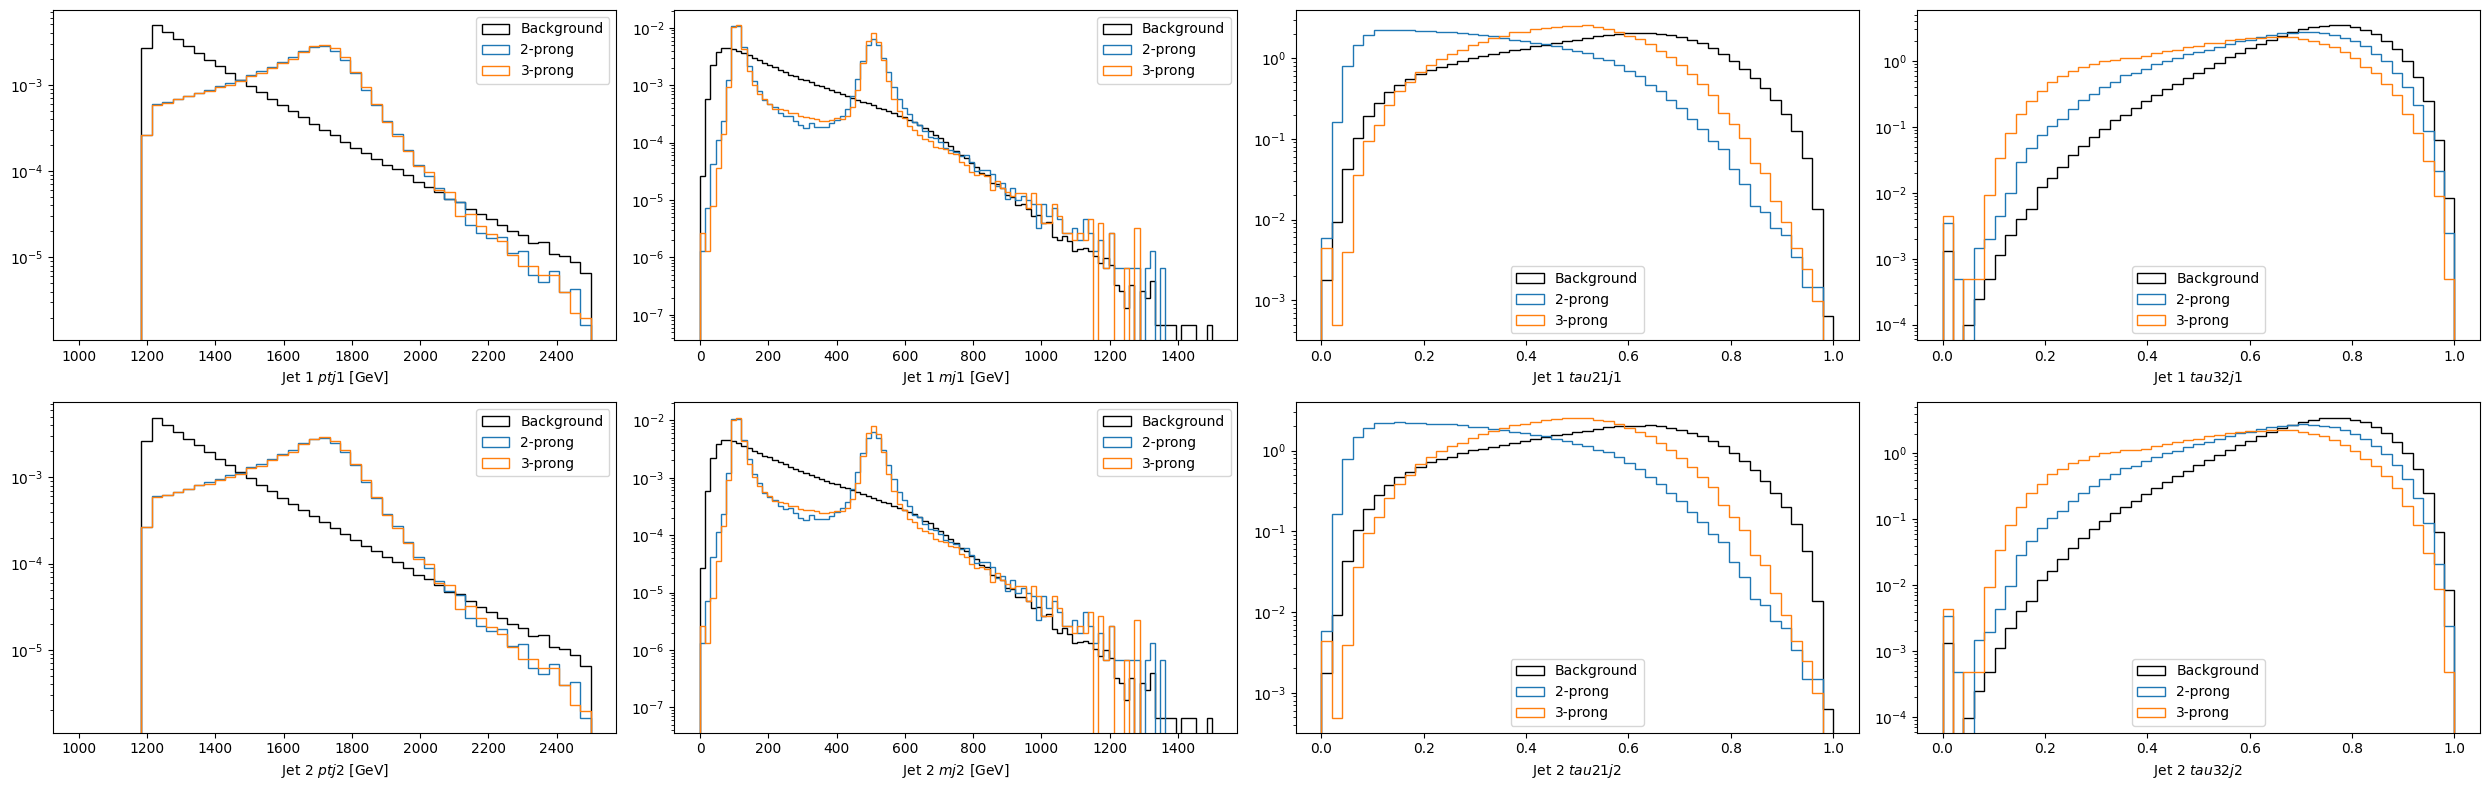

In [40]:
plot_features()

Some differences we can immediately see:
* Both signals tend to have jets with much larger transverse momentum than the background.
* The jet mass distributions for the background are smoothly falling with no resonant structures, whereas for signal the two peaks in the masses of the X and Y bosons are clearly visible at 100 GeV and 500 GeV.
* The n-subjettiness variables $\tau_N$ [arXiv:1011.2268](https://arxiv.org/pdf/1011.2268) are jet shapes that quantify how compatible a jet is with having $N$-subjets, and are clearly different for each process:
   * Jets with $\tau_N \sim 0$ are more compatible with having $N$ or fewer subjets.
   * Jets with $\tau_N >> 0$ are more compatible with having at least $N+1$ subjets.

## Pre-processing

Let's run pre-processing for the variables:

In [41]:
from sklearn.preprocessing import StandardScaler

scl = StandardScaler()
scl = scl.fit(X_train)
X_train_std = scl.transform(X_train)
X_val_std = scl.transform(X_val)
X_test_std = scl.transform(X_test)

In [42]:
# Dataloaders!
batch_size = 4096
train_dl = data.DataLoader(X_train_std, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True,num_workers=2)
val_dl   = data.DataLoader(X_val_std, batch_size=batch_size,num_workers=2)
test_dl  = data.DataLoader(X_test_std, batch_size=batch_size)

# Methods

## Auto-encoders

Auto-encoders (AE) are perhaps the most popular models for anomaly detection. Their task is to read input data and learn to output the same data.

One of the components of AEs is the _encoder_, a series of hidden layers which map the input data to the latent space $z=f(x)$. Another component is the _decoder_ network, which then attempts to reconstruct the original input from the encoded representation, $x^\prime=g(z)$. The loss function can be any function of the form $g(f(x))$ with a mininum at $y=x$. A common choice is the Mean Squared Error (MSE): $\mathcal{L} = |y-x|^2$.

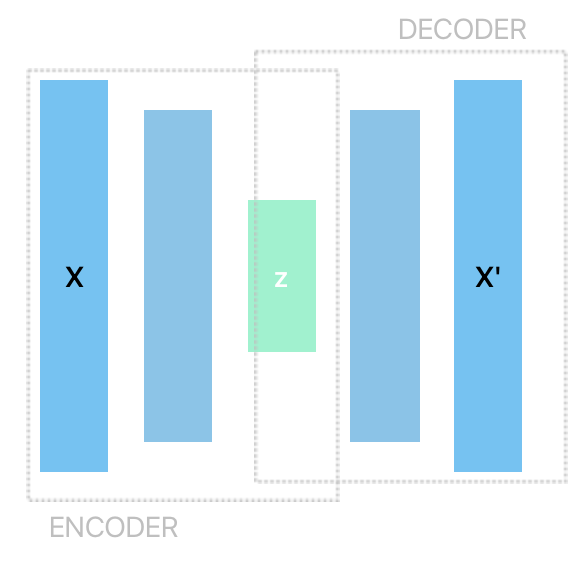

In [43]:
 class AutoEncoder(nn.Module):
  def __init__(self, input_dimension, latent_dimension):
    super().__init__()
    self.input_dimension = input_dimension
    self.latent_dimension = latent_dimension

    self.encoder = nn.Sequential(
      nn.Linear(self.input_dimension, 64, bias=False),
      nn.ReLU(),
      nn.Linear(64, 32, bias=False),
      nn.ReLU(),
      nn.Linear(32, 16, bias=False),
      nn.ReLU(),
      nn.Linear(16, self.latent_dimension, bias=False))
    self.decoder = nn.Sequential(
      nn.Linear(self.latent_dimension, 16, bias=False),
      nn.ReLU(),
      nn.Linear(16, 32, bias=False),
      nn.ReLU(),
      nn.Linear(32, 64, bias=False),
      nn.ReLU(),
      nn.Linear(64, self.input_dimension, bias=False))

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [44]:
input_dimension = 8
latent_dimension = 2

autoencoder = AutoEncoder(input_dimension,latent_dimension)
autoencoder.to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4)

Now that the model is defined, let's compile and train it.

The loss function we'll use is the mean squared error between the input ($X$) and output / reconstructed input ($X^\prime$):



In [45]:
def train_it(num_epochs, model, optimizer, train_dl, val_dl):

    log_dict = {'val_loss_per_epoch': [],
                'train_loss_per_epoch': []}

    loss_fn = F.mse_loss

    for epoch in range(num_epochs):
        val_losses = []
        train_losses = []

        model.train()
        for batch_idx, features_in in enumerate(train_dl):
            # forward
            features_in = features_in.to(device)
            features_in = features_in.float()
            features_out = model(features_in)
            # loss
            loss = loss_fn(features_out, features_in)

            # clear and backpropagate
            optimizer.zero_grad()
            loss.backward()
            train_losses.append(loss.item())

            # parameter update
            optimizer.step()

        model.eval()
        with torch.set_grad_enabled(False):  # save memory during inference
            for batch_idx, features_in in enumerate(val_dl):
                features_in = features_in.to(device)
                features_in = features_in.float()
                features_out = model(features_in)
                val_loss = loss_fn(features_out,features_in)
                val_losses.append(val_loss.item())

        epoch_val_loss = np.average(val_losses)
        epoch_train_loss = np.average(train_losses)

        print('Epoch: ', epoch, '| train loss: %.4f | val loss: %.4f'% (epoch_train_loss,epoch_val_loss))

        log_dict['val_loss_per_epoch'].append(epoch_val_loss)
        log_dict['train_loss_per_epoch'].append(epoch_train_loss)


    return log_dict

### Train

In [ ]:
#history = train_it(200, autoencoder, optimizer, train_dl, val_dl)

Note: one should add early stopping + checkpoints for saving the best model, rather than just running for a fixed number of epochs and saving the last.

Let's look at the training & validation loss history:

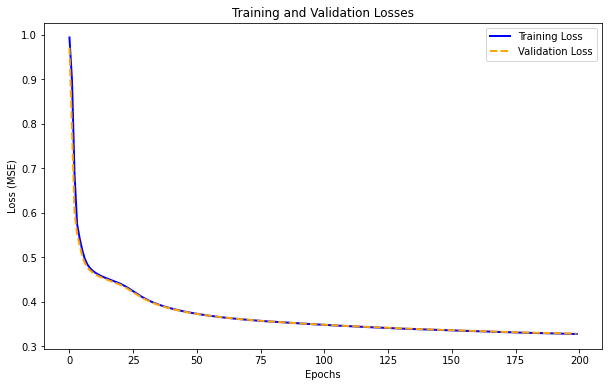

In [ ]:
training_loss = history['train_loss_per_epoch']
validation_loss = history['val_loss_per_epoch']

# Plot training vs validation loss
plt.figure(figsize=(10, 6))
plt.plot(training_loss, label='Training Loss', color='blue', linewidth=2)
plt.plot(validation_loss, label='Validation Loss', color='orange', linestyle='dashed', linewidth=2)

# Add labels, legend, and title
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Losses')
plt.legend()
# Display the plot
plt.show()

In [ ]:
#torch.save(autoencoder.state_dict(), CHECKPOINT_PATH+"/AD-task/autoencoder_model.ckpt")


### Evaluate

Using this trained autoencoder, let's "run the reconstruction" on a different background sample as well as on our BSM signals.

In [ ]:
# optional: reload saved model if you're starting from here
#autoencoder.load_state_dict(torch.load(CHECKPOINT_PATH+"/AD-task/autoencoder_model.ckpt"))

# uncomment this to use the pre-trained model:
# download here
#! wget https://cernbox.cern.ch/s/V60l6ZXAaJNfSKX/download -O saved_models/AD-autoencoder-tutorial.ckpt
# then evaluate
autoencoder.load_state_dict(torch.load(CHECKPOINT_PATH+"/AD-autoencoder-tutorial.ckpt"))
autoencoder.eval()

In [47]:
bkg_prediction = autoencoder.forward(torch.tensor(X_test_std,dtype=torch.float).to(device))
bkg_prediction = bkg_prediction.clone().detach().cpu().numpy()

In [48]:
# 2 prong
twoprong_scaled = scl.transform(df_signal_two)
twoprong_prediction = autoencoder.forward(torch.tensor(twoprong_scaled,dtype=torch.float).to(device))
twoprong_prediction = twoprong_prediction.clone().detach().cpu().numpy()

# 3 prong
threeprong_scaled = scl.transform(df_signal_three)
threeprong_prediction = autoencoder.forward(torch.tensor(threeprong_scaled,dtype=torch.float).to(device))
threeprong_prediction = threeprong_prediction.clone().detach().cpu().numpy()

In other words, we're evaluating our trained model on a new set of samples and recovering our reconstructed input features.

We can see how well our model did by comparing input and output features:

In [49]:
def plot_input_vs_output(ds_in,ds_out,title,color):
    fig, axes = plt.subplots(2,4,figsize=(25,8))

    for f,feat in enumerate(new_features):
        if f<4: jet=0
        else:
            jet=1
            f=f-4

        axes[jet,f].hist(ds_in[:,f],bins=np.linspace(-10,20,100),label="Input",histtype='step',color="black",density=True)
        axes[jet,f].hist(ds_out[:,f],bins=np.linspace(-10,20,100),label="Output",histtype='stepfilled',color=color,density=True)
        axes[jet,f].set_yscale("log")
        axes[jet,f].set_xlabel(r"Jet %d $%s$"%(jet+1,feat))
        axes[jet,f].legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

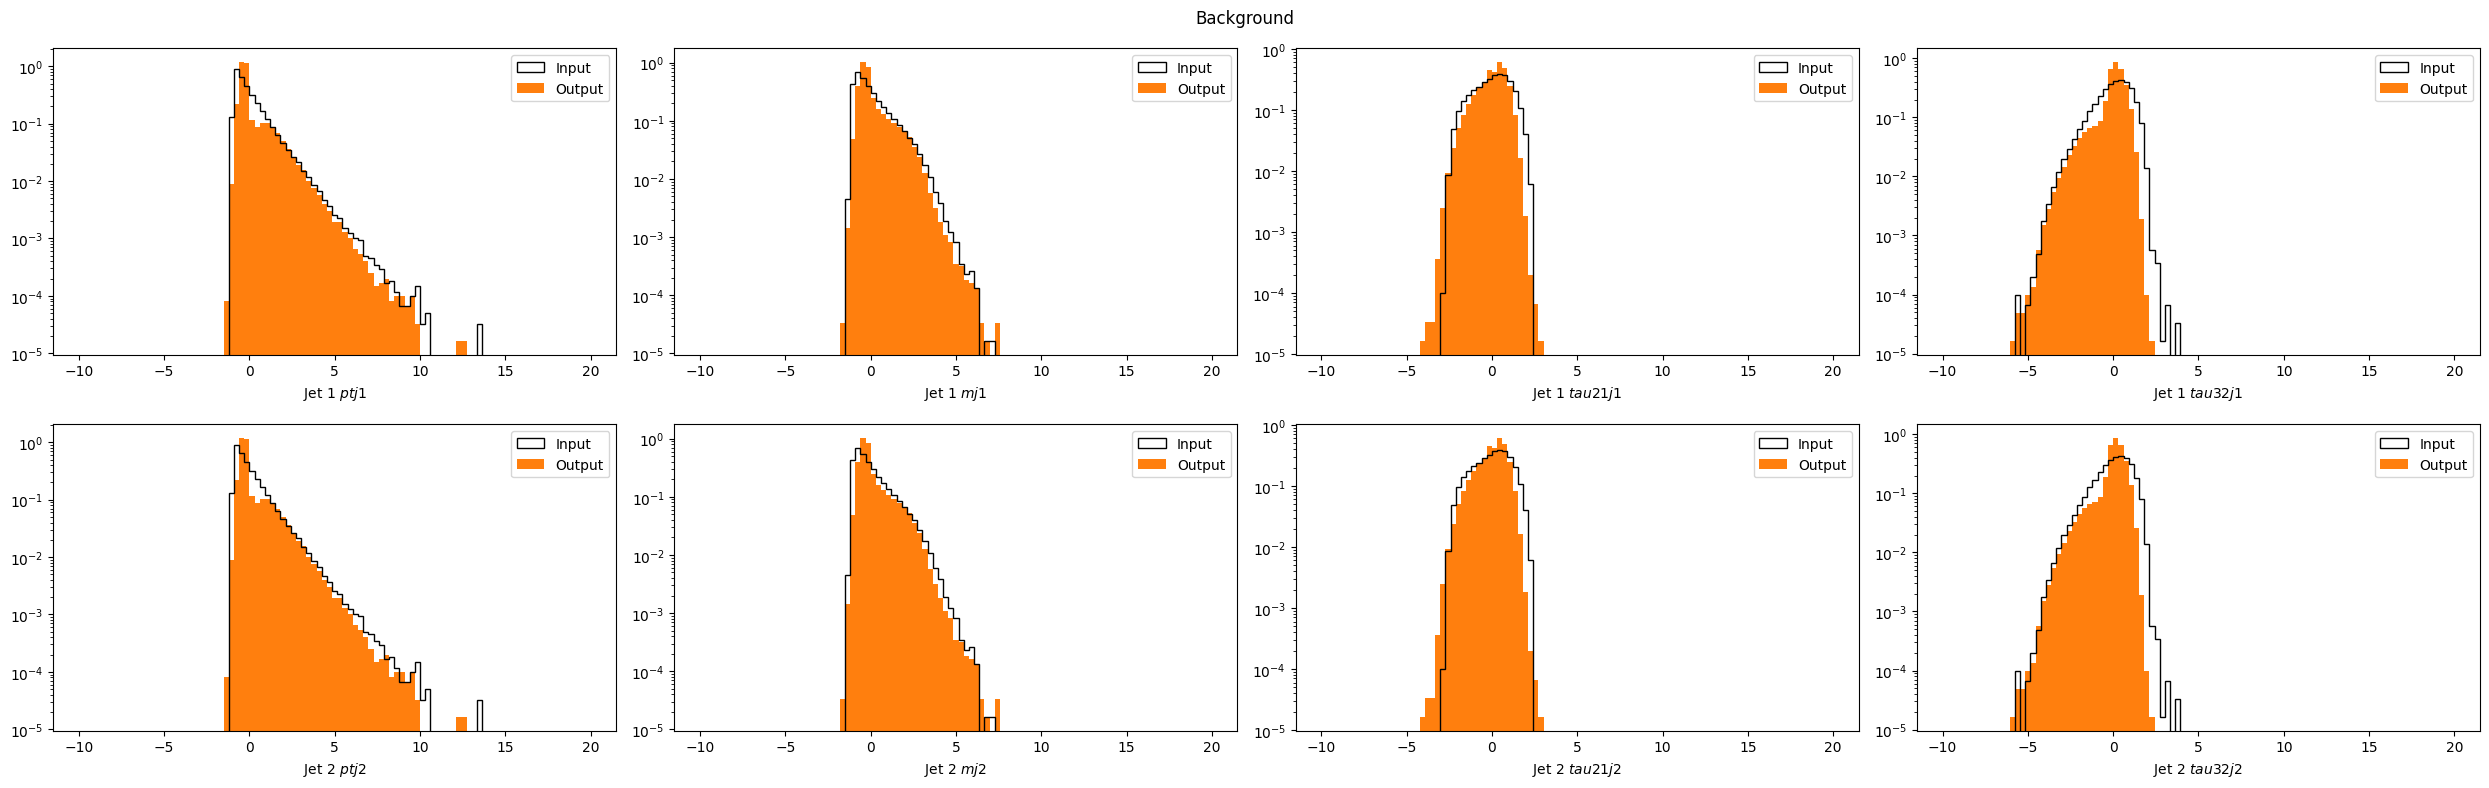

In [50]:
plot_input_vs_output(X_test_std,bkg_prediction,"Background",color="C1")

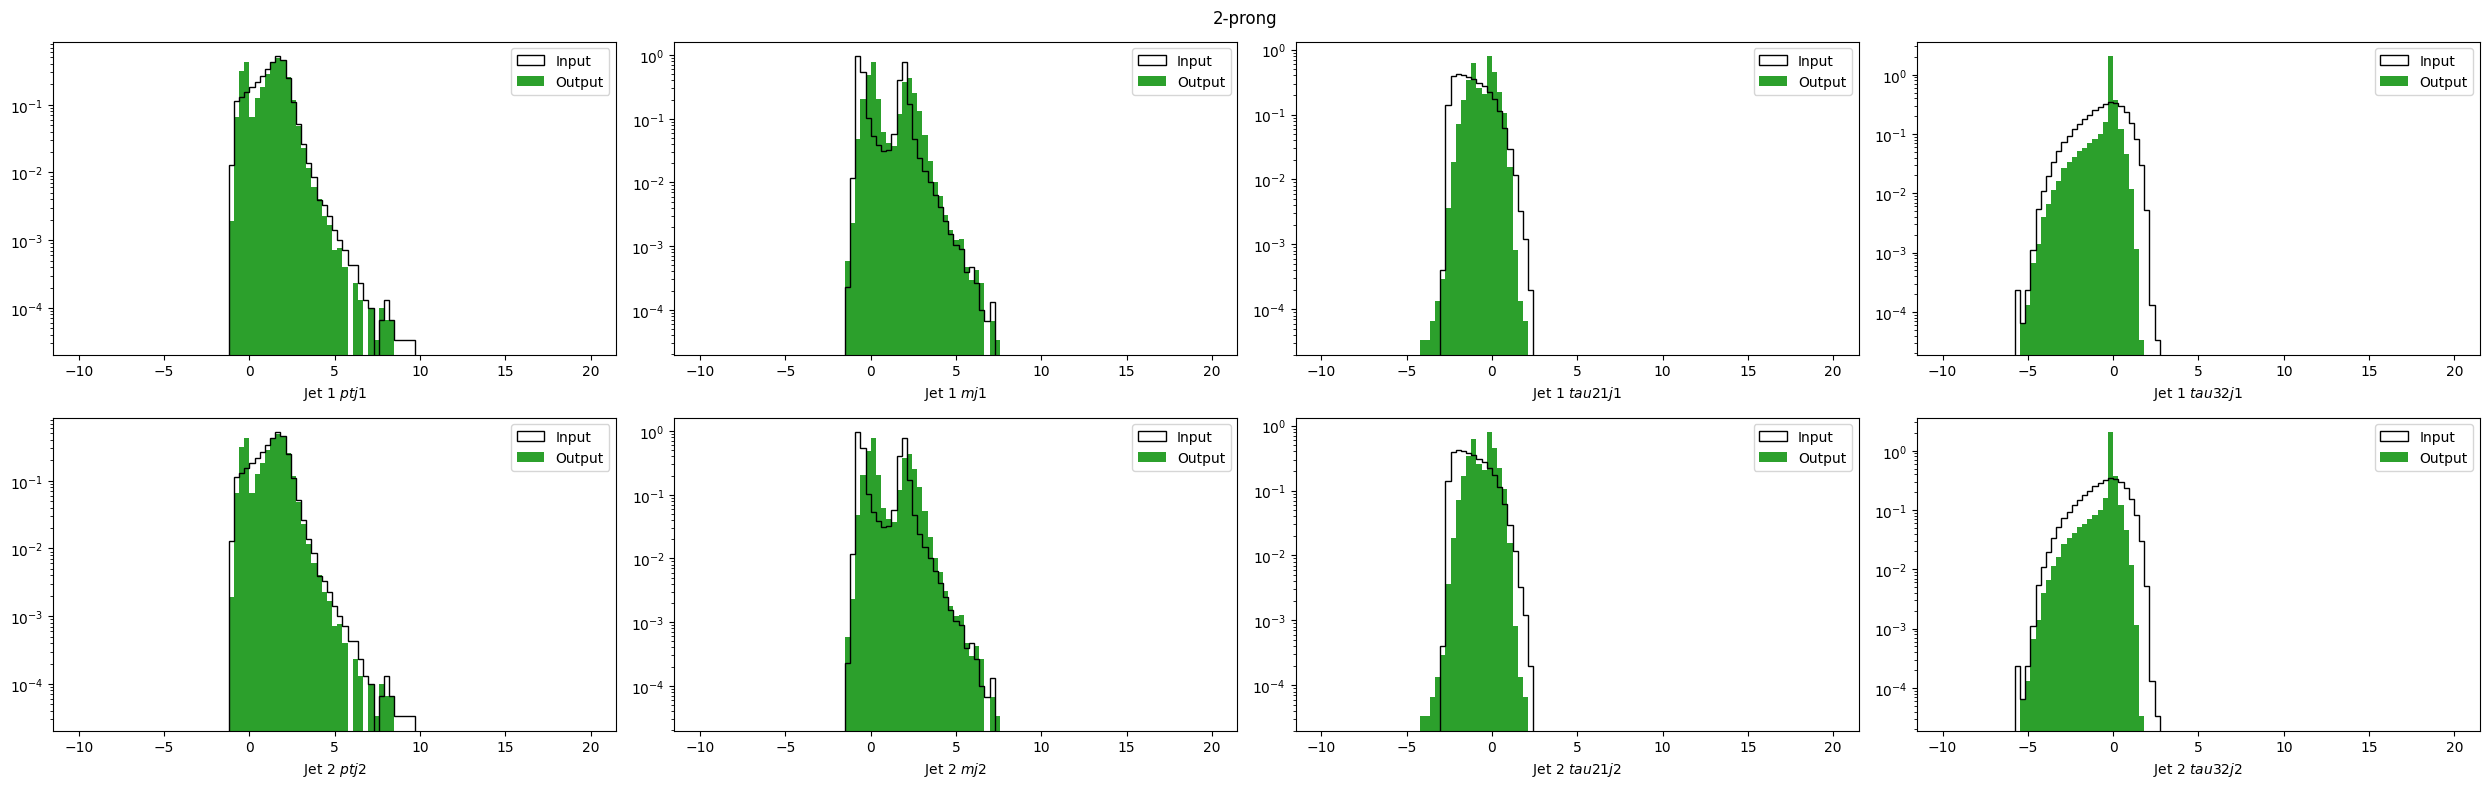

In [51]:
plot_input_vs_output(twoprong_scaled,twoprong_prediction,"2-prong",color="C2")

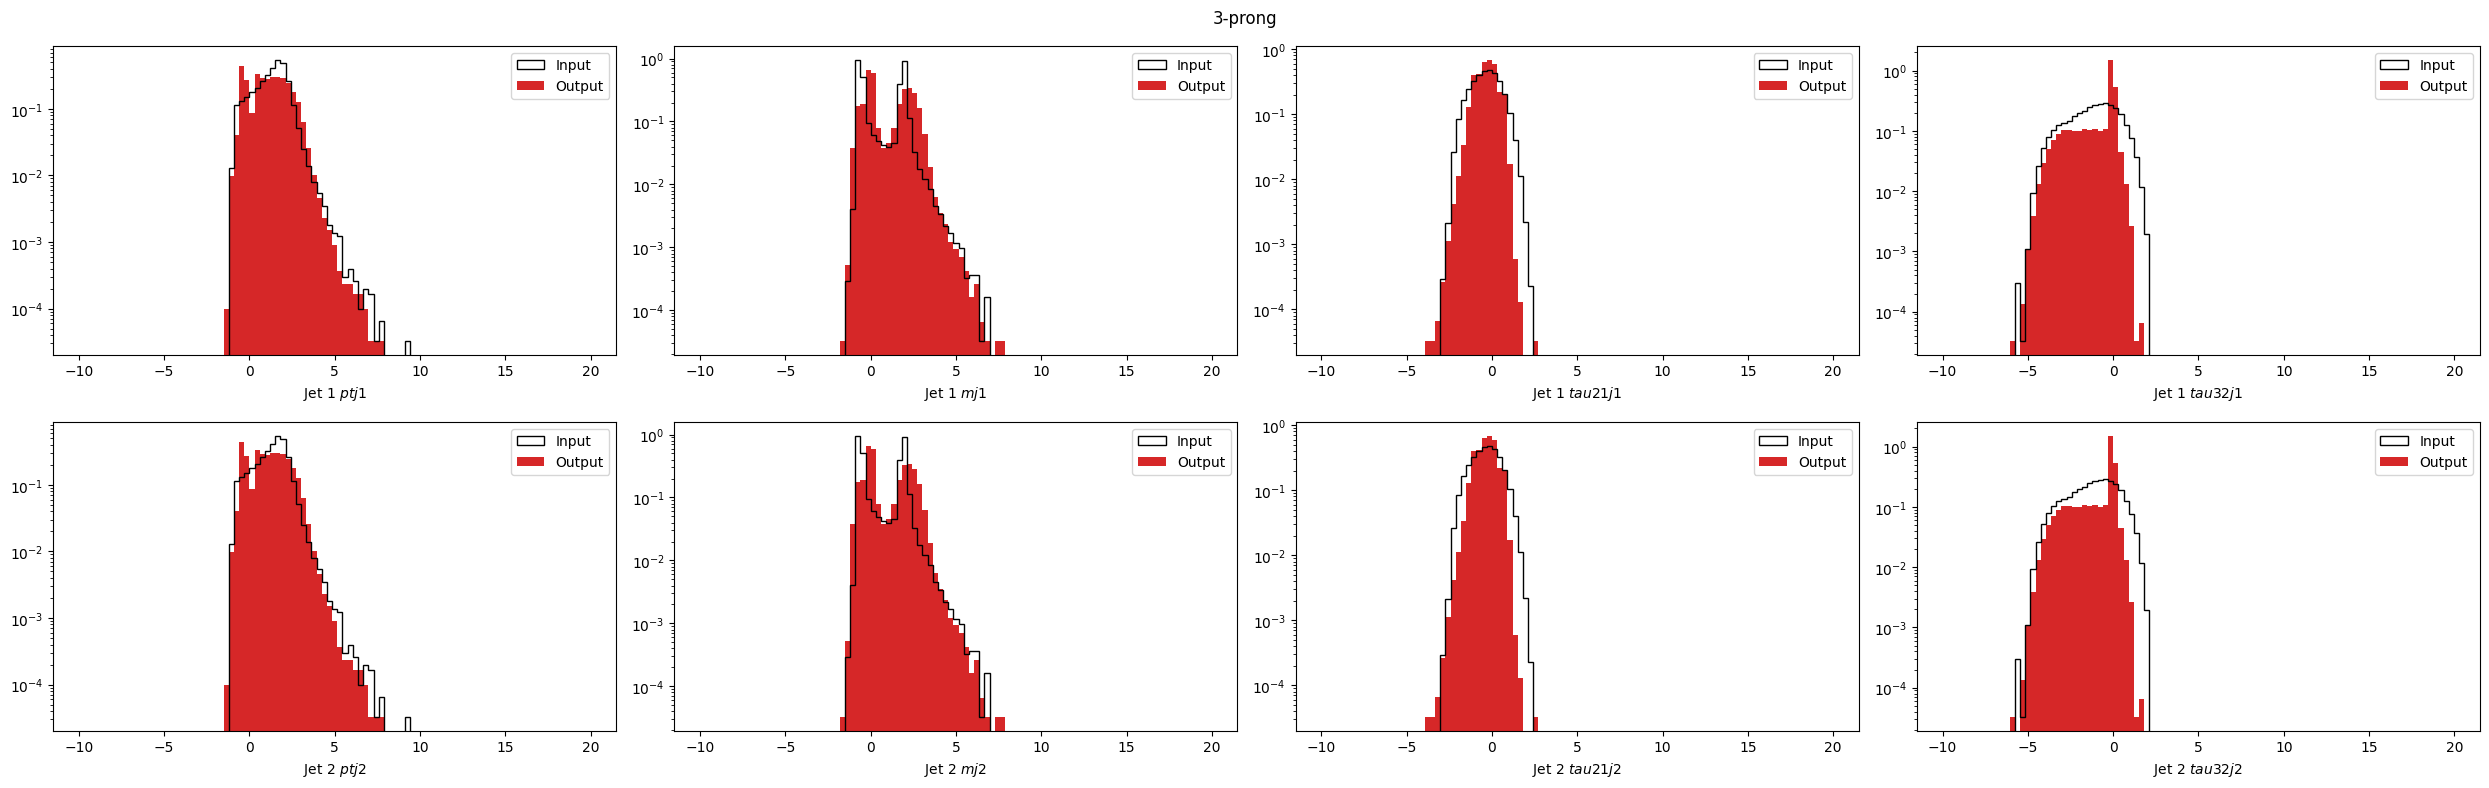

In [52]:
plot_input_vs_output(threeprong_scaled,threeprong_prediction,"3-prong",color="C3")

The MSE which defines the loss is also a good 1D metric to quantify the agreement between input and output, i.e., it's our anomaly metric in this case. The idea is that the compression learned by the AE model doesn't generalize to any sample, and therefore it could potentially help us isolate anomalies.

In [54]:
def mse_loss_func(in_f, out_f):
    sqrdiff = np.square(np.subtract(in_f, out_f))
    return np.mean(sqrdiff,axis=1)

In [55]:
# compute loss value (true, predicted)
total_loss = []
# bkg
print("... background")
total_loss.append(mse_loss_func(X_test_std, bkg_prediction))
# signals
print("... 2-prong")
total_loss.append(mse_loss_func(twoprong_scaled, twoprong_prediction))
print("... 3-prong")
total_loss.append(mse_loss_func(threeprong_scaled, threeprong_prediction))

... background
... 2-prong
... 3-prong


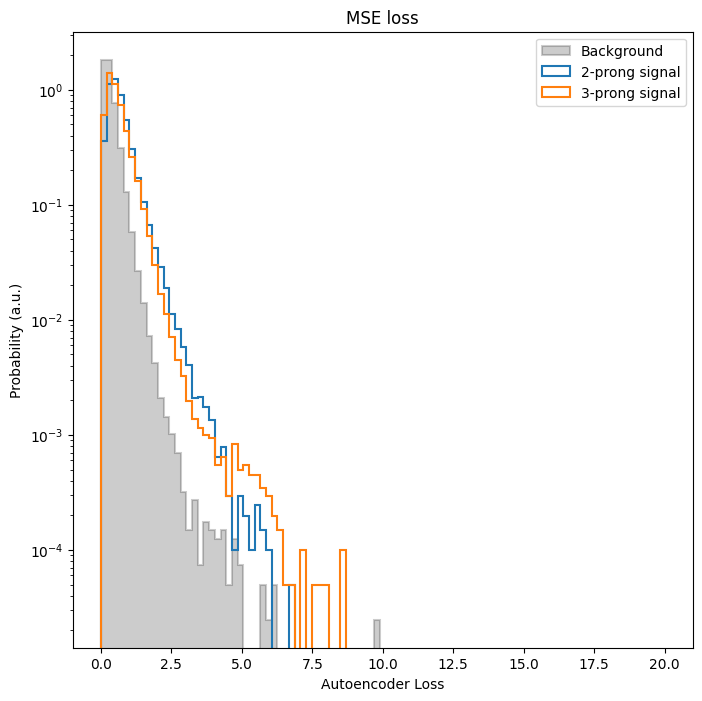

In [56]:
mse_binning = np.linspace(0,20,100)
plt.figure(figsize=(8,8))
#bkg
plt.hist(total_loss[0], bins=mse_binning, label="Background", color="black", density = True, histtype='step', fill=True, alpha=0.2, linewidth=1.5)
#signals
plt.hist(total_loss[1], bins=mse_binning, label="2-prong signal", density = True, histtype='step', fill=False, linewidth=1.5)
plt.hist(total_loss[2], bins=mse_binning, label="3-prong signal", density = True, histtype='step', fill=False, linewidth=1.5)
plt.yscale('log')
plt.xlabel("Autoencoder Loss")
plt.ylabel("Probability (a.u.)")
plt.title('MSE loss')
plt.legend(loc='best')
plt.show()

### ROC

We can turn this into a ROC curve now.

In [57]:
# make a general enough function first

def make_roc(loss_discrim,title): # assume first element is for background, remaining are signals

    target_background = np.zeros(loss_discrim[0].shape[0])

    save_rocs = []

    plt.figure(figsize=(8,6))
    for i, label in enumerate(["2-prong","3-prong"]):

        trueVal = np.concatenate((np.ones(loss_discrim[i+1].shape[0]), target_background)) # anomaly=1, bkg=0
        predVal_loss = np.concatenate((loss_discrim[i+1], loss_discrim[0]))

        fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)

        auc_loss = auc(fpr_loss, tpr_loss)

        plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)'%(label,auc_loss*100.), linewidth=1.5)

        plt.semilogx()
        plt.semilogy()
        plt.ylabel("True Positive Rate")
        plt.xlabel("False Positive Rate")
        plt.legend(loc='center right')

        plt.tight_layout()
        save_rocs.append((fpr_loss,tpr_loss))
    plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
    #plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection efficiency
    plt.title(title)
    plt.show()
    return save_rocs

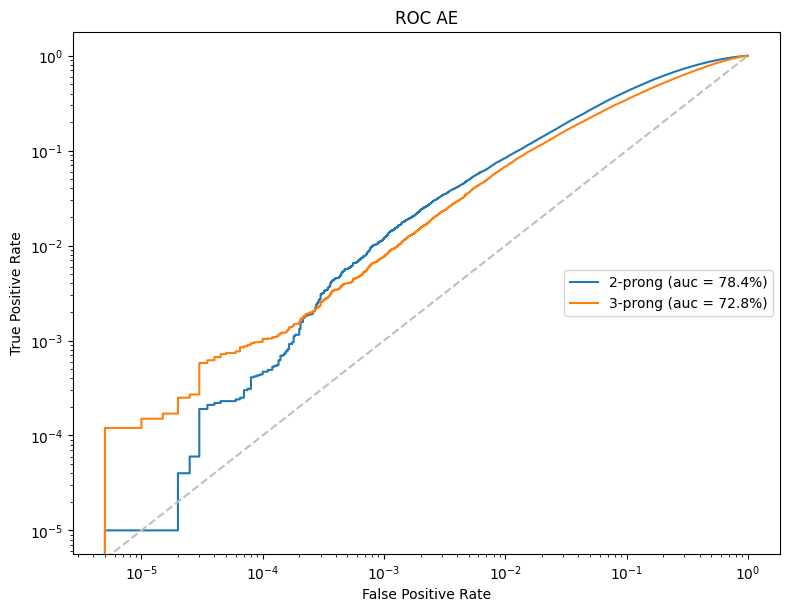

In [58]:
rocs_AE = make_roc(total_loss, "ROC AE")

## Variational auto-encoder

Variational auto-encoders (VAE) [[1312.6114](https://arxiv.org/pdf/1312.6114)] extend the vanilla AEs to perform Bayesian inference. **VAEs are a type of generative model that learn to encode and decode data while imposing a prior constraint on the latent space.**

VAEs assume that the observed data $x$ is generated by some latent random variable $z$. VAEs use variational inference to approximate the true posterior distribution $p(z|x)$ with the approximation $q(z|x)$.

In generative models, the primary goal is to maximize the log-likelihood of the observed data $\log p(x)$. However, directly optimizing $\log p(x)$ is often intractable because it involves integrating over the high-dimensional space of latent variables $z$.

By design, what we can optimise is the Evidence Lower Bound (ELBO), a tractable lower bound on the log-likelihood of the data (the derivation of this relationship is outside of the scope of this tutorial, but some resources are listed at the end of the notebook). The can be decomposed into two terms:

$\mathcal{L}_{\text{ELBO}} = \mathbb{E}_{q(z|x)}[\log p(x|z)] - D_{\text{KL}}(q(z|x) \| p(z)) $

where
- Reconstruction term: $\int q(z|x) \log p(x|z)$ is the reconstruction loss, which measures how well the decoder can reconstruct the input data from the latent variable.
- KL divergence term: $D_{\text{KL}}(q(z|x) \| p(z))$ is the KL divergence term, which measures how close the variational posterior $q(z|x)$ is to the prior $p(z)$.


### Kullback-Leibler (KL) divergence

The KL divergence can be used as metric for the similarity between two distributions, in this case $q(z|x)$ and $p(z|x)$:

$ D_{KL}(q||p)=\int_z q(z|x)\log{\frac{q(z|x)}{p(z|x)}}dx $

By maximising the ELBO (and the marginal log-likelihood of the data $x$), we minimise the KL divergence.

### VAE loss

It follows that the loss function to be minmized during training is the negative ELBO.

$\mathcal{L} = \mathcal{L}_{\text{reco}}+\beta D_{KL}$


* By assuming data to follow a Gaussian distribution with mean $\mu$ and unit variance, the reconstruction loss can be simplified to the MSE (up to a constant): $(x-\mu)^2$.
* By assuming two Gaussians with a diagonal covariance matrix for the latent space $P \sim N (\mu_1,\sigma_1^2)$ and $Q \sim N (\mu_2,\sigma_2^2)$), then the KL divergence has an analytic form:

    $D_{KL}(P||Q)=\log \frac{\sigma_2}{\sigma_1}+\frac{\sigma_1^2+(\mu_1-\mu_2)^2}{2\sigma_2^2}-\frac{1}{2}$

    which can be further simplified for the case where the prior is a standard normal distribution($\mu=0$,$\sigma^2=1$):

    $D_{KL}(P||Q)=-\frac{1}{2} \sum^{D}_{i=1}(1 + \log(\sigma_i^2) - \mu_i^2 - \sigma_i^2)$, where $D$ is the dimensionality of the latent space.


The reconstruction loss ensures that the decoder can accurately reconstruct the input data, while the KL divergence acts as a regularizer, encouraging the latent space to follow a prior distribution. If they match, then using Bayes theorem we know that $p(x)=p(x|z)$, giving us a good generative model.

 In [beta-VAE](https://openreview.net/forum?id=Sy2fzU9gl) it is shown that increasing $\beta$ can help the model learn "disentangled representations" of the data.

### How to differentiate through the stochastic step

The decoder performs a sampling step from $q(z|x)$ in order to recover the input data. The training of the VAE through this stochastic step is possible via the [reparameterization trick](https://arxiv.org/pdf/1312.6114): considering that in our case $z$ is sampled from a Gaussian distribution, $z\sim\mathcal{N}(\mu,\sigma^2)$, the trick is to inject randomness via a variable $\epsilon$ such that $z=\mu+ \sigma \epsilon$, with $\epsilon~\mathcal{N}(0,1)$.

Image from wikipedia:

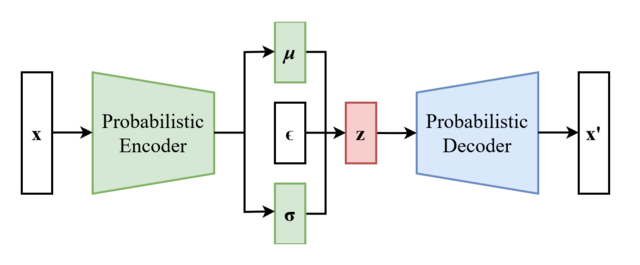

The VAEs are generative models, and they have also been shown to provide competitive performance for anomaly detection; the inclusion of a KL-divergence term in the loss may motivate the model to describe different "classes" of data.

In [59]:
class VAE(nn.Module):

    def __init__(self, input_shape, latent_dimension, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_shape, 64, bias=False),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 32, bias=False),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 16, bias=False),
            nn.LeakyReLU(0.2),
            )

        # latent mean and variance
        self.mean_layer = nn.Linear(16, latent_dimension)
        self.logvar_layer = nn.Linear(16, latent_dimension)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dimension, 16, bias=False),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 32, bias=False),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 64, bias=False),
            nn.LeakyReLU(0.2),
            nn.Linear(64, input_shape)
            )

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var)
        z = mean + var*epsilon  # reparameterization trick
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

In [60]:
input_shape = 8
latent_dimension = 1
vae = VAE(input_shape,latent_dimension).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)


In [61]:
def train_it_variational(num_epochs, model, optimizer, train_dl, val_dl):

    log_dict = {'val_loss_per_epoch': [],
                'train_loss_per_epoch': [],
                'val_reco_loss_per_epoch': [],
                'val_kl_loss_per_epoch': [],
                'train_reco_loss_per_epoch': [],
                'train_kl_loss_per_epoch': []}

    def loss_function(x, x_hat, mean, log_var):
        reco_loss = F.mse_loss(x_hat, x, reduction="mean")
        kld = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp()) # sum over latent space
        beta = 1
        loss = reco_loss + beta*kld
        return loss, (reco_loss, kld)

    for epoch in range(num_epochs):
        val_losses = []
        train_losses = []

        train_reco_loss = []
        train_kl_loss = []

        val_reco_loss = []
        val_kl_loss = []
        model.train()
        for batch_idx, features_in in enumerate(train_dl):
            # forward
            features_in = features_in.float().to(device)
            xhat, mean, logvar = model(features_in)
            # loss
            loss, (reco_loss, kl_loss) = loss_function(features_in, xhat, mean, logvar)

            # clear and backpropagate
            optimizer.zero_grad()
            loss.backward()
            train_losses.append(loss.item())
            train_reco_loss.append(reco_loss.item())
            train_kl_loss.append(kl_loss.item())

            # parameter update
            optimizer.step()

        model.eval()
        with torch.set_grad_enabled(False):  # save memory during inference
            for batch_idx, features_in in enumerate(val_dl):
                features_in = features_in.float().to(device)
                xhat, mean, logvar = model(features_in)
                val_loss, (reco_loss, kl_loss) = loss_function(features_in, xhat, mean, logvar)
                val_losses.append(val_loss.item())
                val_reco_loss.append(reco_loss.item())
                val_kl_loss.append(kl_loss.item())

        epoch_val_loss = np.average(val_losses)
        epoch_train_loss = np.average(train_losses)
        epoch_train_reco_loss = np.average(train_reco_loss)
        epoch_train_kl_loss = np.average(train_kl_loss)
        epoch_val_reco_loss = np.average(val_reco_loss)
        epoch_val_kl_loss = np.average(val_kl_loss)

        print('Epoch: ', epoch, '| train loss: %.3f | val loss: %.3f (reco=%.3f, kl=%.3f)'% (epoch_train_loss,epoch_val_loss,epoch_val_reco_loss,epoch_val_kl_loss))

        if epoch % 10 == 0: torch.save(model.state_dict(), CHECKPOINT_PATH+"/AD-task/epoch%d_vae.ckpt"%epoch)

        log_dict['val_loss_per_epoch'].append(epoch_val_loss)
        log_dict['val_kl_loss_per_epoch'].append(epoch_val_kl_loss)
        log_dict['val_reco_loss_per_epoch'].append(epoch_val_reco_loss)

        log_dict['train_loss_per_epoch'].append(epoch_train_loss)
        log_dict['train_reco_loss_per_epoch'].append(epoch_train_reco_loss)
        log_dict['train_kl_loss_per_epoch'].append(epoch_train_kl_loss)


    return log_dict

### Train

In [ ]:
#history = train_it_variational(500, vae, optimizer, train_dl, val_dl)

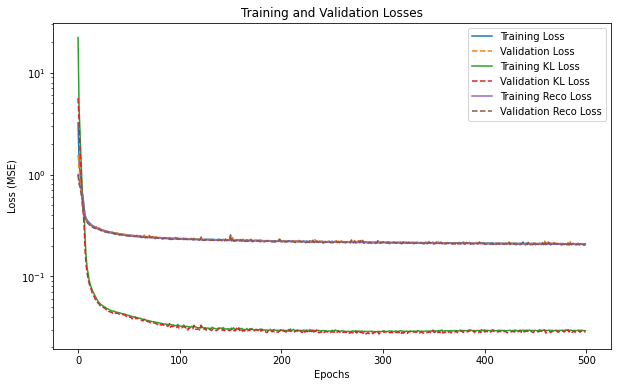

In [ ]:
training_loss = history["train_loss_per_epoch"]
train_reco_loss = history["train_reco_loss_per_epoch"]
train_kl_loss = history["train_kl_loss_per_epoch"]
validation_loss = history["val_loss_per_epoch"]
val_reco_loss = history["val_reco_loss_per_epoch"]
val_kl_loss = history["val_kl_loss_per_epoch"]

# Plot training vs validation loss
plt.figure(figsize=(10, 6))
plt.plot(training_loss, label='Training Loss')#, color='blue', linewidth=2)
plt.plot(validation_loss, label='Validation Loss', linestyle='dashed')#, color='orange', linestyle='dashed', linewidth=2)

plt.plot(train_kl_loss, label='Training KL Loss')#, color='blue', linewidth=2)
plt.plot(val_kl_loss, label='Validation KL Loss', linestyle='dashed')#, color='orange', linestyle='dashed', linewidth=2)

plt.plot(train_reco_loss, label='Training Reco Loss')#, color='blue', linewidth=2)
plt.plot(val_reco_loss, label='Validation Reco Loss', linestyle='dashed')#, color='orange', linestyle='dashed', linewidth=2)

# Add labels, legend, and title
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Losses')
plt.legend()
plt.yscale("log")
# Display the plot
plt.show()

*TODO*: comment on loss behavior

In [ ]:
# save it
#torch.save(vae.state_dict(), CHECKPOINT_PATH+"/AD-task/vae_model.ckpt")

### Evaluate

In [ ]:
# optional: reload saved model if you're starting from here
#vae.load_state_dict(torch.load(CHECKPOINT_PATH+"/AD-task/vae_model.ckpt"))

# uncomment this to use the pre-trained model:
# download
#! wget https://cernbox.cern.ch/s/F2YDxQbknCQcpZ0/download -O saved_models/AD-vae-tutorial.ckpt
# eval
vae.load_state_dict(torch.load(CHECKPOINT_PATH+"/AD-vae-tutorial.ckpt"))
vae.eval()

In [63]:
bkg_prediction_vae = vae.forward(torch.tensor(X_test_std,dtype=torch.float).to(device))
pred_bkg, mean_bkg, logvar_bkg = bkg_prediction_vae

In [64]:
pred_bkg = pred_bkg.detach().cpu().numpy()
mean_bkg = mean_bkg.detach().cpu().numpy()
logvar_bkg = logvar_bkg.detach().cpu().numpy()

In [65]:
# 2 prong
twoprong_scaled = scl.transform(df_signal_two)
pred_two, mean_two, logvar_two = vae.forward(torch.tensor(twoprong_scaled,dtype=torch.float).to(device))
pred_two = pred_two.clone().detach().cpu().numpy()
mean_two = mean_two.clone().detach().cpu().numpy()
logvar_two = logvar_two.clone().detach().cpu().numpy()

# 3 prong
threeprong_scaled = scl.transform(df_signal_three)
pred_three, mean_three, logvar_three = vae.forward(torch.tensor(threeprong_scaled,dtype=torch.float).to(device))
pred_three = pred_three.clone().detach().cpu().numpy()
mean_three = mean_three.clone().detach().cpu().numpy()
logvar_three = logvar_three.clone().detach().cpu().numpy()

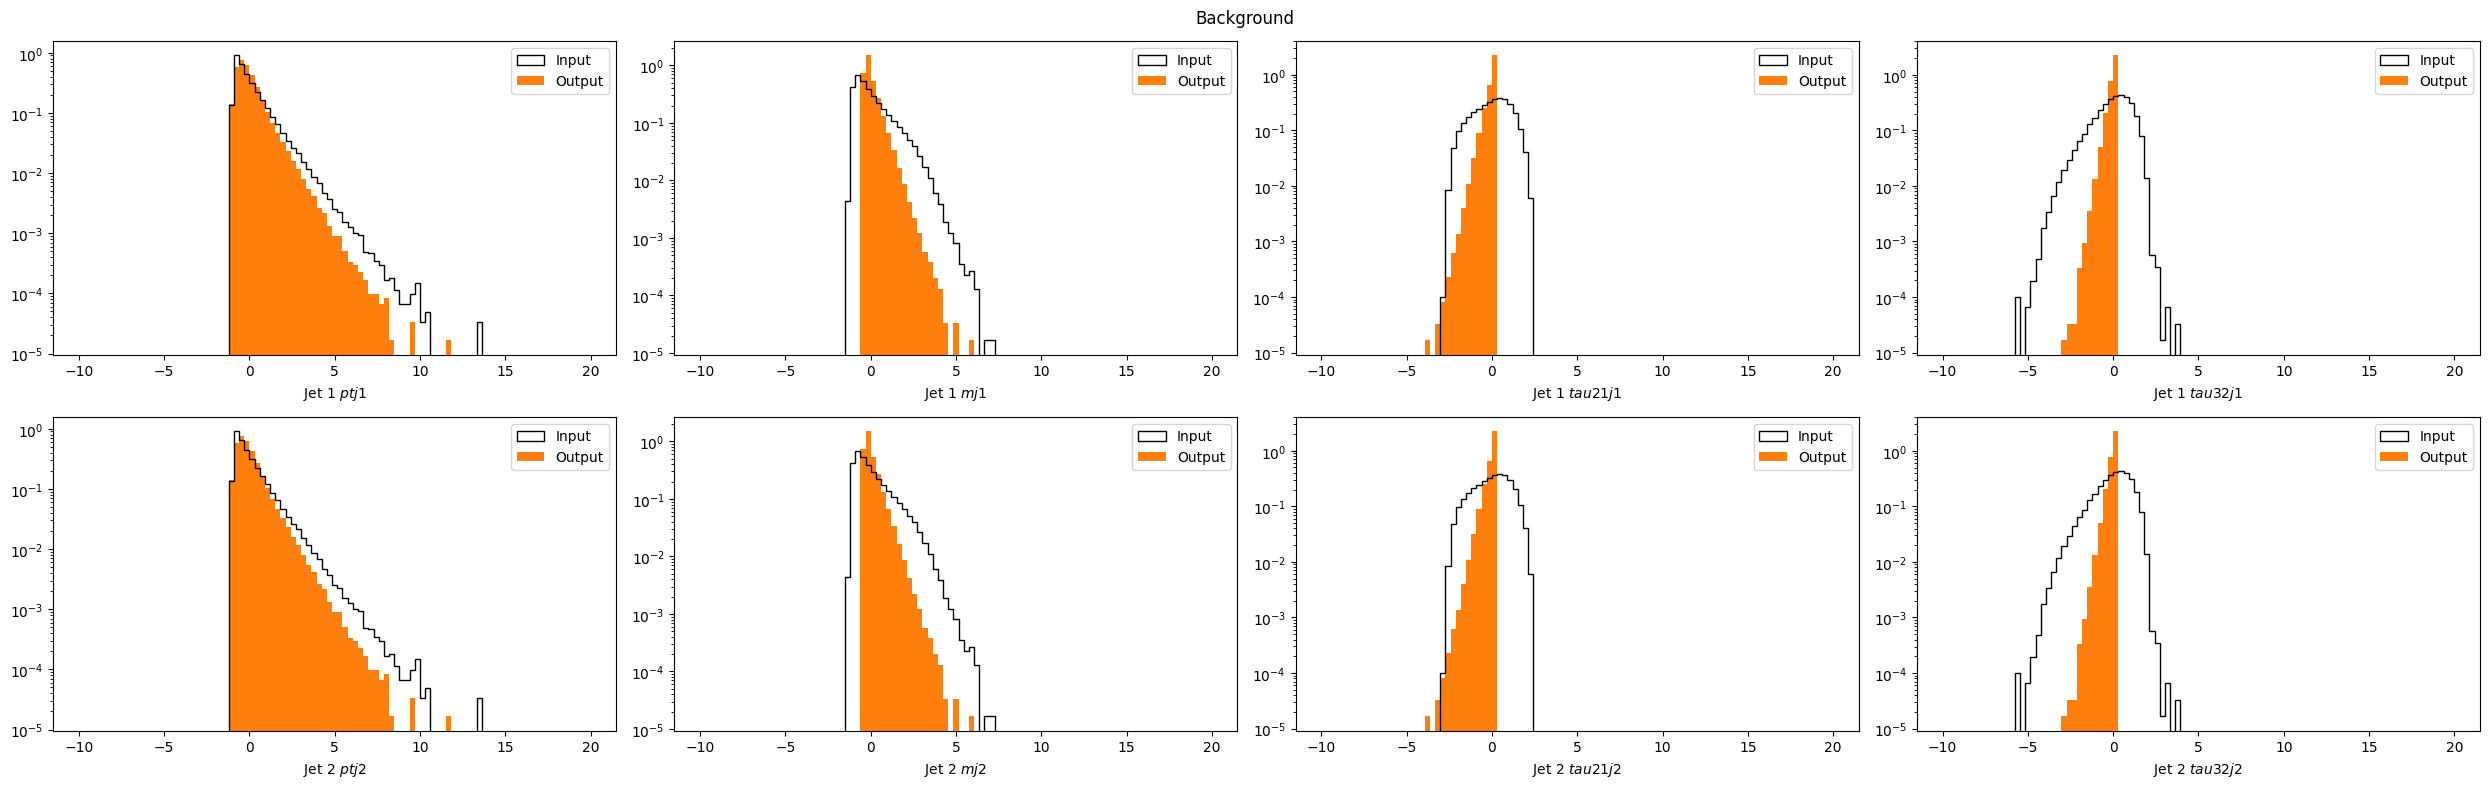

In [66]:
plot_input_vs_output(X_test_std,pred_bkg,"Background",color="C1")

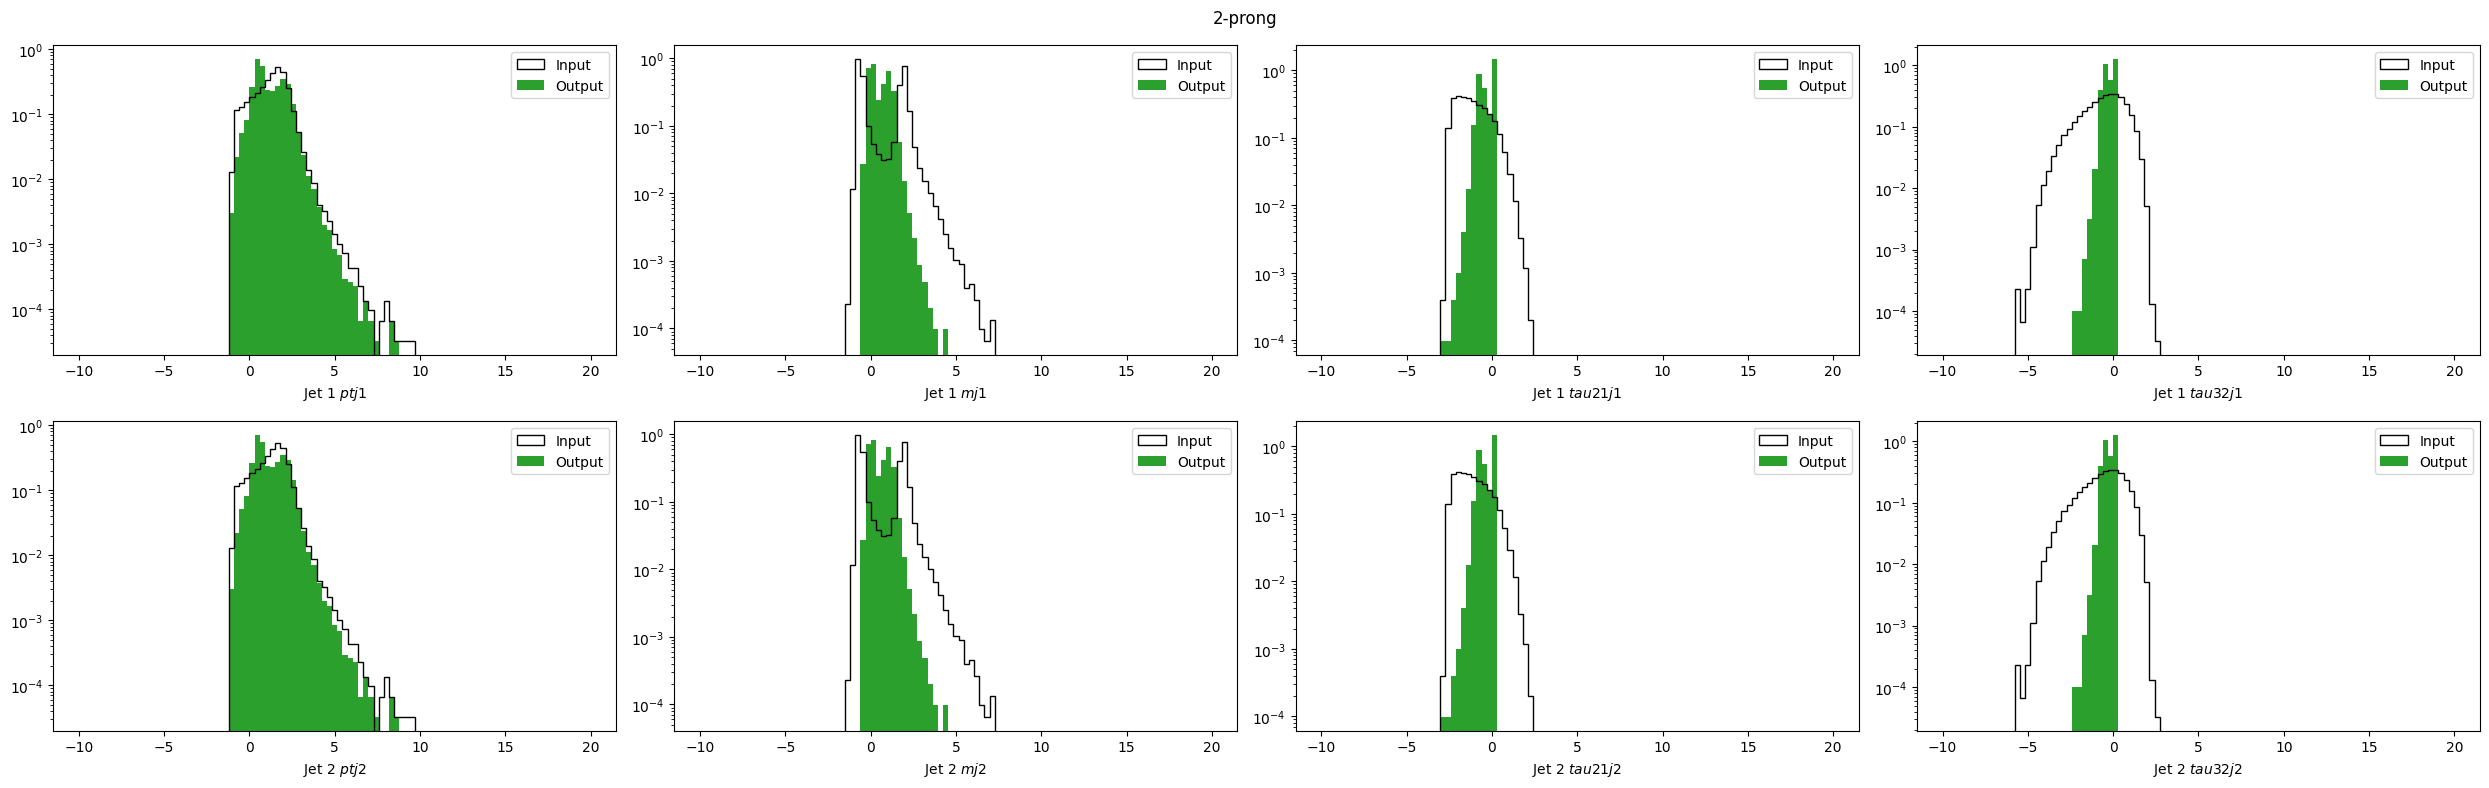

In [67]:
plot_input_vs_output(twoprong_scaled,pred_two,"2-prong",color="C2")

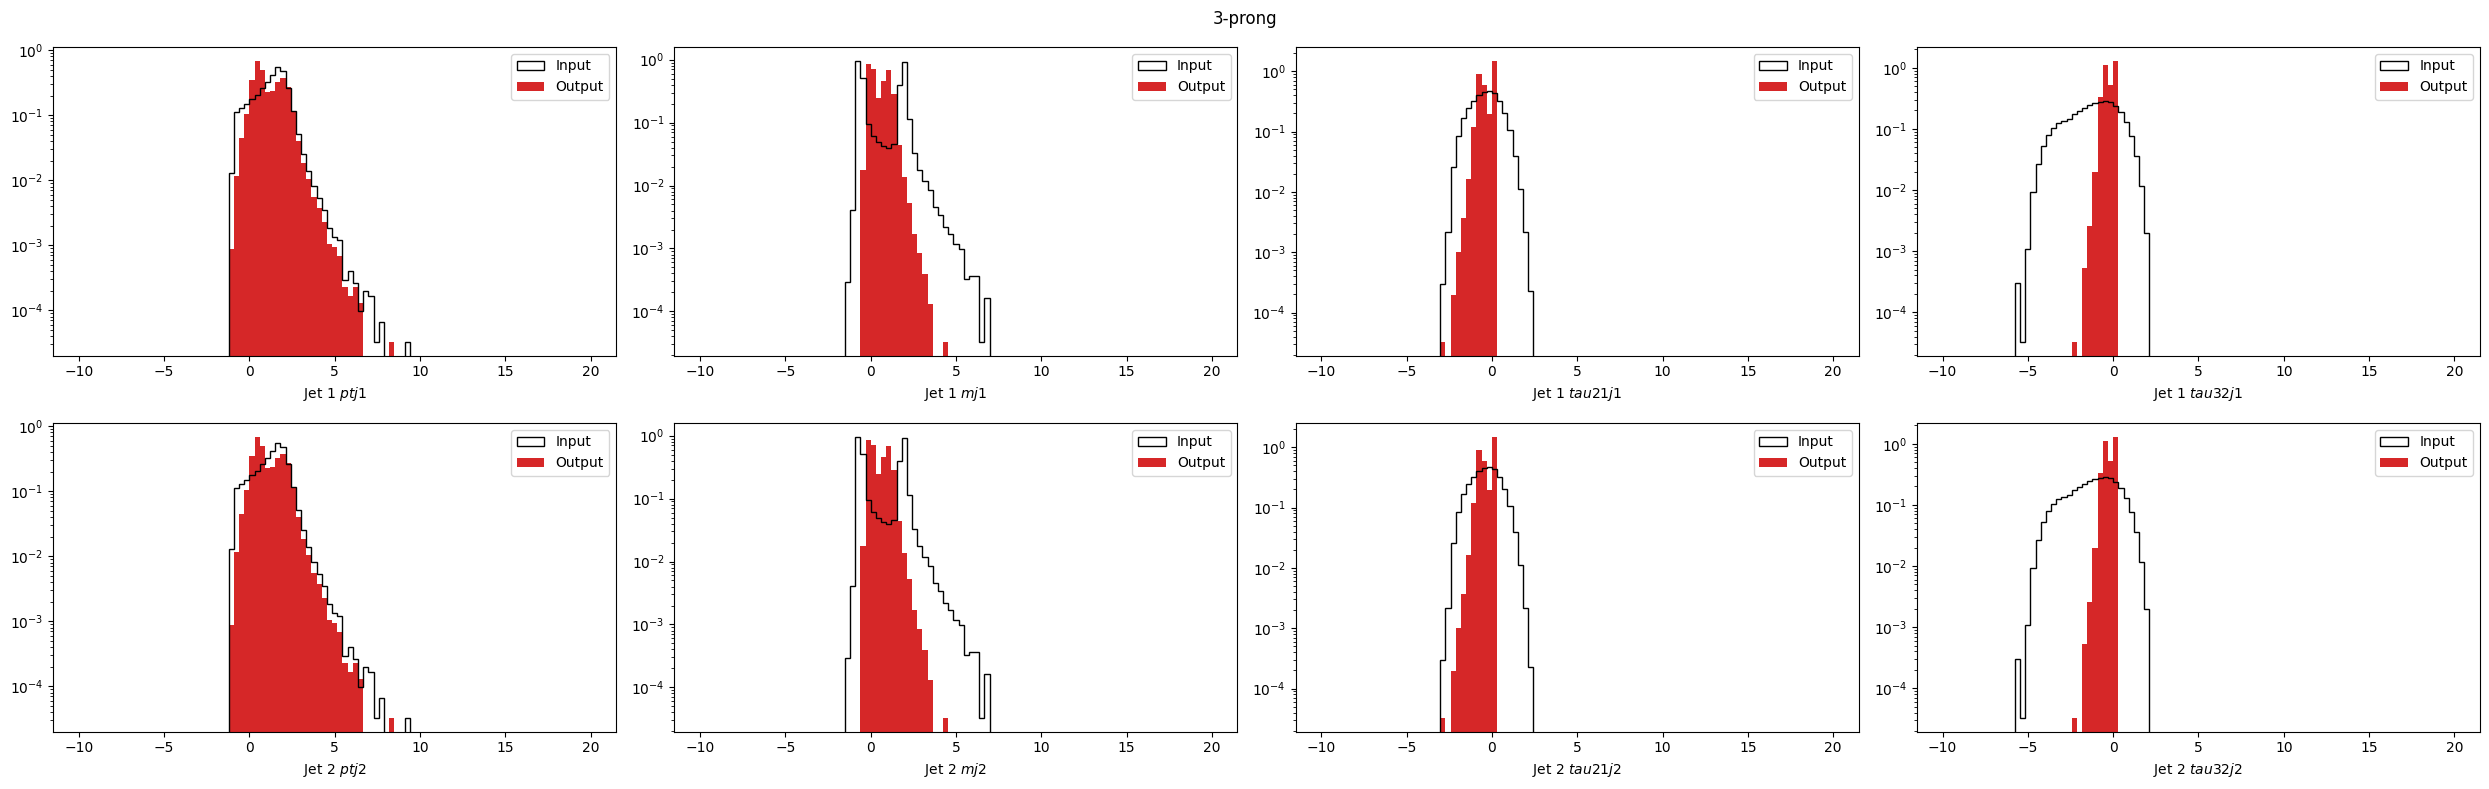

In [68]:
plot_input_vs_output(threeprong_scaled,pred_three,"3-prong",color="C3")

Now we'll want to look at both MSE and the KL-losses as discriminants:

In [69]:
def kl_loss_func(mu, logvar):
    kl_div = -0.5 * np.sum(1 + logvar - mu**2 - np.exp(logvar), axis=1)
    return kl_div

In [70]:
# compute loss value (true, predicted)
mse_loss = []
# bkg
print("... background")
mse_loss.append(mse_loss_func(X_test_std, bkg_prediction))
# signals
print("... 2-prong")
mse_loss.append(mse_loss_func(twoprong_scaled, pred_two))
print("... 3-prong")
mse_loss.append(mse_loss_func(threeprong_scaled, pred_three))

... background
... 2-prong
... 3-prong


In [71]:
# compute loss value (true, predicted)
kl_loss = []
# bkg
print("... background")
kl_loss.append(kl_loss_func(mean_bkg, logvar_bkg))
# signals
print("... 2-prong")
kl_loss.append(kl_loss_func(mean_two, logvar_two))
print("... 3-prong")
kl_loss.append(kl_loss_func(mean_three, logvar_three))

... background
... 2-prong
... 3-prong


In [72]:
# combined
beta = 1
combined_loss = []
for i,process in enumerate(["background", "2-prong", "3-prong"]):
    print("... %s"%process)
    combined_loss.append(beta*kl_loss[i]+mse_loss[i])

... background
... 2-prong
... 3-prong


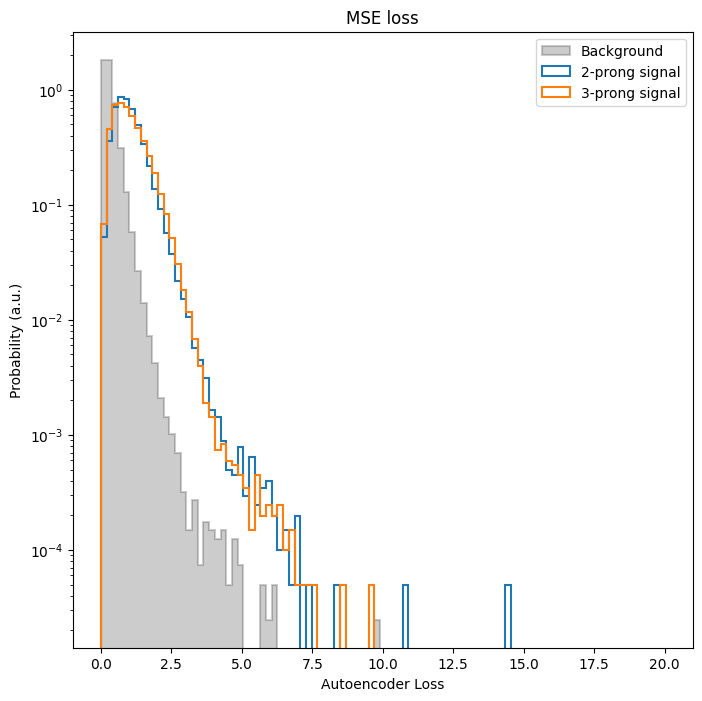

In [73]:
mse_binning = np.linspace(0,20,100)
plt.figure(figsize=(8,8))
#bkg
plt.hist(mse_loss[0], bins=mse_binning, label="Background", color="black", density = True, histtype='step', fill=True, alpha=0.2, linewidth=1.5)
#signals
plt.hist(mse_loss[1], bins=mse_binning, label="2-prong signal", density = True, histtype='step', fill=False, linewidth=1.5)
plt.hist(mse_loss[2], bins=mse_binning, label="3-prong signal", density = True, histtype='step', fill=False, linewidth=1.5)
plt.yscale('log')
plt.xlabel("Autoencoder Loss")
plt.ylabel("Probability (a.u.)")
plt.title('MSE loss')
plt.legend(loc='best')
plt.show()

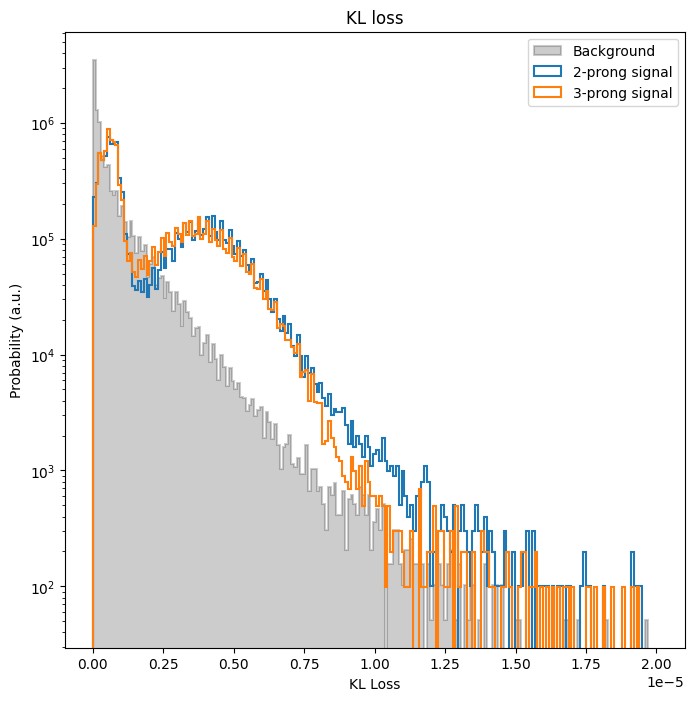

In [74]:
kl_binning = np.linspace(0,2e-5,200)
plt.figure(figsize=(8,8))
#bkg
plt.hist(kl_loss[0], bins=kl_binning, label="Background", color="black", density = True, histtype='step', fill=True, alpha=0.2, linewidth=1.5)
#signals
plt.hist(kl_loss[1], bins=kl_binning, label="2-prong signal", density = True, histtype='step', fill=False, linewidth=1.5)
plt.hist(kl_loss[2], bins=kl_binning, label="3-prong signal", density = True, histtype='step', fill=False, linewidth=1.5)
plt.yscale('log')
plt.xlabel("KL Loss")
plt.ylabel("Probability (a.u.)")
plt.title('KL loss')
plt.legend(loc='best')
plt.show()

### ROC

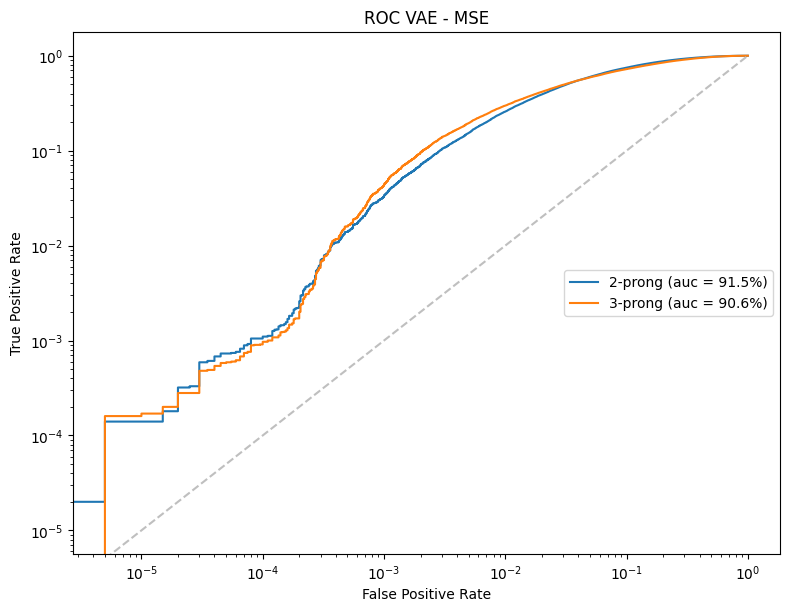

In [75]:
rocs_vae_mse = make_roc(mse_loss,title="ROC VAE - MSE")

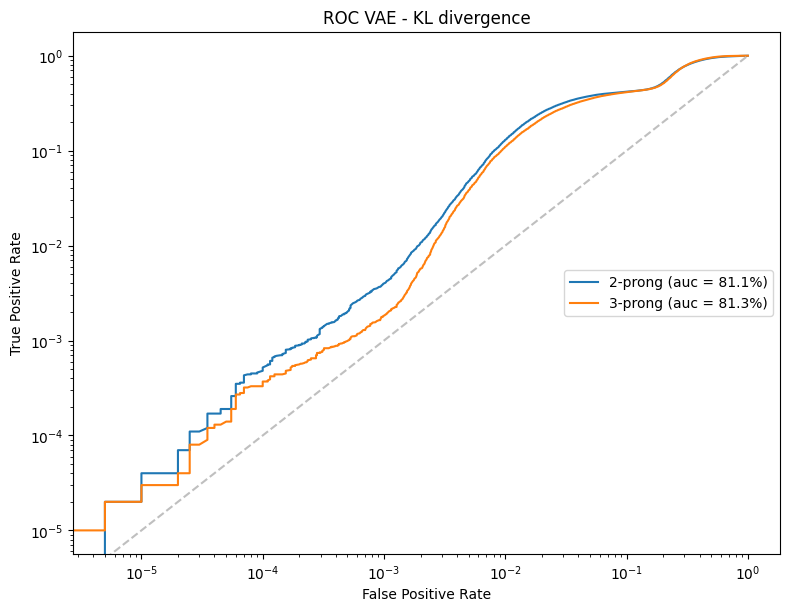

In [76]:
rocs_vae_kl = make_roc(kl_loss,title="ROC VAE - KL divergence")

# ROC curve - compare methods

In [77]:
def compare_rocs(roc_methods,id):

    for i,label in enumerate(["2-prong","3-prong"]):

        plt.figure(figsize=(6,4))
        for method,result in enumerate(roc_methods):
            fpr_loss, tpr_loss = result[i]
            auc_loss = auc(fpr_loss, tpr_loss)
            plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)'%(id[method],auc_loss*100.), linewidth=1.5)
            plt.semilogx()
            plt.semilogy()
            plt.ylabel("True Positive Rate")
            plt.xlabel("False Positive Rate")
            plt.legend(loc='center right')
            plt.title(label)
            plt.tight_layout()

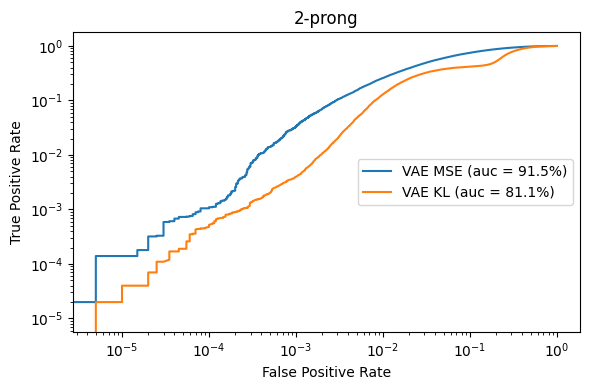

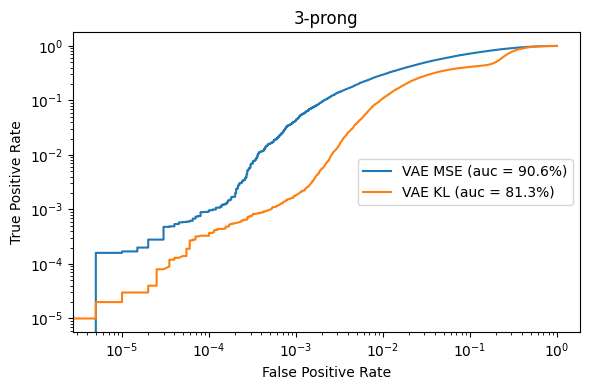

In [78]:
compare_rocs([rocs_vae_mse, rocs_vae_kl],["VAE MSE", "VAE KL"])

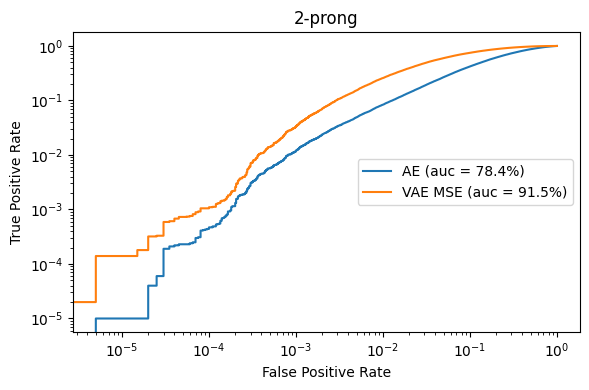

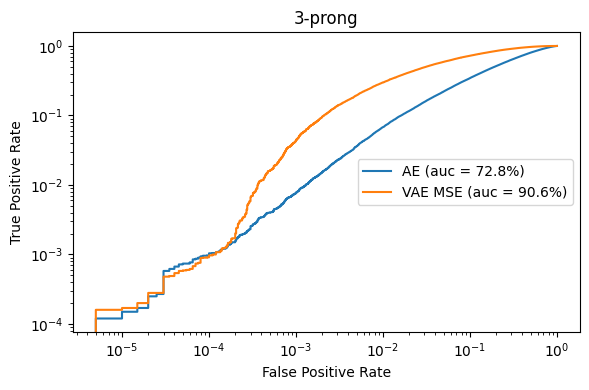

In [79]:
compare_rocs([rocs_AE, rocs_vae_mse],["AE", "VAE MSE"])

# Choose your own adventure

1. Explore the relationship between increasing the latent space dimension and the best choice for $\beta$ value.
2. Compare your anomaly detection algorithm to supervised learning: train two dense networks for a binary (signal vs background) or a single one for multi-classification (2-prong vs 3-prong vs background) and compare the obtained performance against the AD methods.
3. Investigate the events in the tails of the KL and reco loss distributions: what are their main characteristics? Make a plot of the invariant di-jet mass for signal and background: what do you find?

# Further reading

* Evidence, KL-divergence, and ELBO: https://mpatacchiola.github.io/blog/2021/01/25/intro-variational-inference.html
* The LHC Olympics 2020: https://arxiv.org/abs/2101.08320
* Autoencoders for anomaly detection in the trigger: https://arxiv.org/abs/2108.03986
* Distance Correlation regularisation: https://arxiv.org/abs/2001.05310